<a href="https://colab.research.google.com/github/sujata1712/EnsembleACPredict---Machine-Learning-Project/blob/main/EnsembleACPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EnsembleACPredict: An Ensemble Machine Learning Framework for Anticancer Peptide (ACP) Classification with LGBM‑Based Feature Importance**
---

## Project Summary:
This project aims to classify peptide sequences as **anticancer (ACP)** or **non-anticancer** using machine learning.
  We use **Pfeature** to extract descriptors, apply feature selection & scaling, train multiple models, and build an **ensemble** for the best performance.
  LightGBM feature importance is also analyzed to provide biological interpretability.

## Data Description:
- **Dataset:** Anticancer & Non-Anticancer peptide dataset (e.g., ENNAACT)  
- **Inputs:** Amino acid sequences  
- **Target:** ACP (1) / Non-ACP (0)   


## Objective:
- Build a robust ML framework to classify ACPs vs non-ACPs  
- Analyze key features using **LightGBM importance**    
- Provide a reproducible model for **drug candidate prioritization**  



# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Required Libraries
  We import all the necessary Python libraries for data processing, feature extraction, and model building.

In [ ]:
!pip install lazypredict

  Using cached lazypredict-0.2.16-py2.py3-none-any.whl.metadata (13 kB)
Using cached lazypredict-0.2.16-py2.py3-none-any.whl (14 kB)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix,matthews_corrcoef
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,roc_curve,auc

from lazypredict.Supervised import LazyClassifier

import joblib

import warnings
warnings.filterwarnings("ignore")

# Load the DataSet
Load the Anticancer and Non-anticancer Peptide Sequences  dataset into a pandas DataFrame for analysis.

In [ ]:
# Anticancer peptide sequences from file
with open("/content/drive/MyDrive/Drug Prediction from ACPs/anticancer_peptide_Main_Dataset_ENNAACT.txt",'r') as f1:
  acps=[]
  for line in f1:
    if not line.startswith(">") :             #ignoring FASTA headers starting with ">"
        acps.append(line.strip())

#Non- Anticancer peptide
with open("/content/drive/MyDrive/Drug Prediction from ACPs/non-anticancer_Peptide_Main_Dataset_ENNAACT.txt",'r') as f2:
  non_acps=[]
  for line in f2:
    if not line.startswith(">") :             #ignoring FASTA headers starting with ">"
        non_acps.append(line.strip())

In [ ]:
#Create Dataframe
df= pd.DataFrame({
    "sequence": acps+non_acps,
    "label": [1]*len(acps)+[0]*len(non_acps)        #labels: 1 for ACPs, 0 for non-ACPs
})
df.head()

,sequence,label
0,ACDCRGDCFCGGGGIVRRADRAAVP,1
1,ACYCRIPACIAGERRYGTCIYQGRLWAFCC,1
2,ECRRLCYKQRCVTYCRGR,1
3,FFGWLIKGAIHAGKAIHGLIHRRRH,1
4,FLPAIVGAAAKFLPKIFCAISKKC,1


In [ ]:
df.shape

(5958, 2)

In [ ]:
df['label'].value_counts()

,count
label,
0,5298
1,660


# Pfeature Set up
Initialize and configure Pfeature for peptide descriptor extraction.

In [ ]:
# download Pfeature.zip from GitHub
!wget -O /content/Pfeature.zip https://github.com/raghavagps/Pfeature/raw/master/PyLib/Pfeature.zip

--2025-08-22 06:35:26--  https://github.com/raghavagps/Pfeature/raw/master/PyLib/Pfeature.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/raghavagps/Pfeature/master/PyLib/Pfeature.zip [following]
--2025-08-22 06:35:27--  https://raw.githubusercontent.com/raghavagps/Pfeature/master/PyLib/Pfeature.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519486 (507K) [application/zip]
Saving to: ‘/content/Pfeature.zip’

/content/Pfeature.z 100%[===================>] 507.31K  --.-KB/s    in 0.03s   

2025-08-22 06:35:27 (14.7 MB/s) - ‘/content/Pfeature.zip’ saved [519486/519486]



In [ ]:
# Unzip it
from zipfile import ZipFile
file_name = "/content/Pfeature.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall("/content")

In [ ]:
# Install the package manually
%cd /content/Pfeature
!python setup.py install

/content/Pfeature
/usr/local/lib/python3.12/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.12/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See htt

# Feature Extraction using Pfeature
Extract numerical descriptors (AAC, AAB,PCP, PCB, DPC, PAAC) from peptide sequences using Pfeature.

In [ ]:
from Pfeature.pfeature import aac_wp,aab_wp,pcp_wp,pcb_wp,dpc_wp,paac_wp

In [ ]:
# Define functions for extracting different features
def aac(input_path):
    output_path = input_path.replace('.txt', 'aac.csv')
    aac_wp(input_path, output_path)
    return pd.read_csv(output_path)

def aab(input_path):
    output_path = input_path.replace('.txt', 'aab.csv')
    aab_wp(input_path, output_path)
    return pd.read_csv(output_path)

def pcb(input_path):
    output_path = input_path.replace('.txt', 'pcb.csv')
    pcb_wp(input_path, output_path)
    return pd.read_csv(output_path)

def pcp(input_path):
    output_path = input_path.replace('.txt', 'pcp.csv')
    pcp_wp(input_path, output_path)
    return pd.read_csv(output_path)

def dpc(input_path):
    output_path = input_path.replace('.txt', 'dpc.csv')
    dpc_wp(input_path, output_path,lg=1)#add default values for lg
    return pd.read_csv(output_path)

def paac(input_path, lg=10, pw=0.05):
    output_path = input_path.replace('.txt', 'paac.csv')
    paac_wp(input_path, output_path,lg=1,pw=0.05)#add default values for lg and pw
    return pd.read_csv(output_path)

In [ ]:
# Input paths
pos= "/content/drive/MyDrive/Drug Prediction from ACPs/anticancer_peptide_Main_Dataset_ENNAACT.txt"
neg = "/content/drive/MyDrive/Drug Prediction from ACPs/non-anticancer_Peptide_Main_Dataset_ENNAACT.txt"

# Unified feature + label function
def feature_calc(po, ne, feature_func, label_name):
    po_feature = feature_func(po)
    ne_feature = feature_func(ne)
    po_class = pd.Series(['ACP'] * len(po_feature), name=label_name)
    ne_class = pd.Series(['non-ACP'] * len(ne_feature), name=label_name)
    po_ne_class = pd.concat([po_class, ne_class], axis=0)
    po_ne_feature = pd.concat([po_feature, ne_feature], axis=0)
    return pd.concat([po_ne_feature, po_ne_class], axis=1)

In [ ]:
# Generate all features
feature1 = feature_calc(pos, neg, aac, 'class1')
feature2 = feature_calc(pos, neg, aab, 'class2')
feature3 = feature_calc(pos, neg, pcb, 'class3')
feature4 = feature_calc(pos, neg, pcp, 'class4')
feature5 = feature_calc(pos, neg, dpc, 'class5')
feature6 = feature_calc(pos, neg, paac, 'class6')

In [ ]:
feature1

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y,class1
0,16.00,16.00,12.00,0.00,4.00,20.00,0.00,4.00,0.00,0.00,...,0.00,4.00,0.00,16.00,0.00,0.00,8.00,0.00,0.00,ACP
1,13.33,20.00,0.00,3.33,3.33,10.00,0.00,10.00,0.00,3.33,...,0.00,3.33,3.33,13.33,0.00,3.33,0.00,3.33,10.00,ACP
2,0.00,22.22,0.00,5.56,0.00,5.56,0.00,0.00,5.56,5.56,...,0.00,0.00,5.56,27.78,0.00,5.56,5.56,0.00,11.11,ACP
3,12.00,0.00,0.00,0.00,8.00,16.00,16.00,16.00,8.00,8.00,...,0.00,0.00,0.00,12.00,0.00,0.00,0.00,4.00,0.00,ACP
4,20.83,8.33,0.00,0.00,12.50,4.17,0.00,12.50,16.67,8.33,...,0.00,8.33,0.00,0.00,4.17,0.00,4.17,0.00,0.00,ACP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5293,14.29,7.14,0.00,0.00,21.43,7.14,7.14,0.00,0.00,21.43,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.14,14.29,non-ACP
5294,9.09,0.00,18.18,18.18,0.00,9.09,0.00,0.00,9.09,0.00,...,0.00,0.00,0.00,0.00,9.09,0.00,0.00,0.00,0.00,non-ACP
5295,10.00,0.00,0.00,10.00,10.00,0.00,6.67,3.33,6.67,13.33,...,0.00,3.33,13.33,0.00,10.00,3.33,3.33,0.00,6.67,non-ACP
5296,14.29,0.00,7.14,14.29,0.00,3.57,3.57,7.14,3.57,17.86,...,0.00,3.57,0.00,10.71,7.14,0.00,3.57,0.00,0.00,non-ACP


In [ ]:
# Combine all feature sets
df = pd.concat([feature1,feature2,feature3,feature4,feature5,feature6] , axis =1)

In [ ]:
df = df.drop(['class2','class3','class4','class5','class6'] , axis = 1)

In [ ]:
df.isnull().sum().sum()

np.int64(4703310)

In [ ]:
df = df.fillna(0)

In [ ]:
df

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,PAAC1_N,PAAC1_P,PAAC1_Q,PAAC1_R,PAAC1_S,PAAC1_T,PAAC1_V,PAAC1_W,PAAC1_Y,PAAC1_lam1
0,16.00,16.00,12.00,0.00,4.00,20.00,0.00,4.00,0.00,0.00,...,0.00,4.00,0.00,16.00,0.00,0.00,8.00,0.00,0.00,0.10
1,13.33,20.00,0.00,3.33,3.33,10.00,0.00,10.00,0.00,3.33,...,0.00,3.33,3.33,13.33,0.00,3.33,0.00,3.33,10.00,0.11
2,0.00,22.22,0.00,5.56,0.00,5.56,0.00,0.00,5.56,5.56,...,0.00,0.00,5.56,27.78,0.00,5.56,5.56,0.00,11.11,0.14
3,12.00,0.00,0.00,0.00,8.00,16.00,16.00,16.00,8.00,8.00,...,0.00,0.00,0.00,12.00,0.00,0.00,0.00,4.00,0.00,0.09
4,20.83,8.33,0.00,0.00,12.50,4.17,0.00,12.50,16.67,8.33,...,0.00,8.33,0.00,0.00,4.17,0.00,4.17,0.00,0.00,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5293,14.29,7.14,0.00,0.00,21.43,7.14,7.14,0.00,0.00,21.43,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.14,14.29,0.09
5294,9.09,0.00,18.18,18.18,0.00,9.09,0.00,0.00,9.09,0.00,...,0.00,0.00,0.00,0.00,9.09,0.00,0.00,0.00,0.00,0.10
5295,10.00,0.00,0.00,10.00,10.00,0.00,6.67,3.33,6.67,13.33,...,0.00,3.33,13.33,0.00,10.00,3.33,3.33,0.00,6.67,0.06
5296,14.29,0.00,7.14,14.29,0.00,3.57,3.57,7.14,3.57,17.86,...,0.00,3.57,0.00,10.71,7.14,0.00,3.57,0.00,0.00,0.12


# Feature Selection & Feature Scaling
Remove redundant features and apply scaling to standardize the data

In [ ]:
# Separate features & target
label_map = {'ACP': 1, 'non-ACP': 0}

y = df['class1'].map(label_map).values
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
len(y)

5957

In [ ]:
X = df.drop(columns=['class1'])
X.shape

(5957, 2271)

In [ ]:
# remove low-variance features
selector = VarianceThreshold(threshold=0.1)
X_sel = selector.fit_transform(X)

selected_columns = X.columns[selector.get_support()]
X = pd.DataFrame(X_sel, columns=selected_columns)

X.shape

(5957, 930)

In [ ]:
# Scaling
ss=StandardScaler()
X_scaled=ss.fit_transform(X)
X=pd.DataFrame(X_scaled,columns=X.columns)
X.head()

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,PAAC1_M,PAAC1_N,PAAC1_P,PAAC1_Q,PAAC1_R,PAAC1_S,PAAC1_T,PAAC1_V,PAAC1_W,PAAC1_Y
0,1.05,3.35,1.30,-1.00,-0.01,1.95,-0.61,-0.36,-0.99,-1.31,...,-0.64,-0.83,-0.14,-0.78,1.64,-1.04,-0.96,0.20,-0.44,-0.69
1,0.68,4.30,-0.96,-0.47,-0.15,0.40,-0.61,0.69,-0.99,-0.87,...,-0.64,-0.83,-0.27,-0.09,1.21,-1.04,-0.33,-1.16,0.78,1.91
2,-1.17,4.83,-0.96,-0.12,-0.84,-0.29,-0.61,-1.06,-0.15,-0.58,...,-0.64,-0.83,-0.90,0.36,3.51,-1.04,0.09,-0.21,-0.44,2.20
3,0.50,-0.45,-0.96,-1.00,0.83,1.33,3.83,1.74,0.22,-0.26,...,-0.64,-0.83,-0.90,-0.78,1.00,-1.04,-0.96,-1.16,1.02,-0.69
4,1.72,1.53,-0.96,-1.00,1.78,-0.50,-0.61,1.13,1.52,-0.22,...,-0.64,-0.83,0.69,-0.78,-0.90,-0.33,-0.96,-0.45,-0.44,-0.69


# Train/Test Split
Split the dataset into training and testing sets with stratification for balanced classes.


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
X_test

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,PAAC1_M,PAAC1_N,PAAC1_P,PAAC1_Q,PAAC1_R,PAAC1_S,PAAC1_T,PAAC1_V,PAAC1_W,PAAC1_Y
3368,3.09,-0.45,0.49,-1.00,-0.84,1.23,-0.61,0.29,-0.99,1.71,...,-0.64,-0.83,-0.90,-0.78,-0.90,-1.04,0.48,0.15,-0.44,-0.69
4680,1.43,-0.45,0.22,0.99,-0.19,-0.67,-0.61,-1.06,-0.99,0.33,...,0.30,-0.83,1.49,0.51,1.58,-1.04,-0.37,-0.63,-0.44,-0.69
1955,-0.35,-0.45,0.15,-0.07,0.39,0.67,-0.61,-1.06,-0.99,-0.54,...,-0.64,0.45,0.22,-0.78,0.03,-0.04,2.35,-1.16,-0.44,3.90
2937,-1.17,-0.45,0.15,-1.00,0.39,1.58,1.02,-1.06,-0.10,-0.54,...,1.13,-0.83,0.22,-0.78,0.03,-1.04,2.35,1.85,-0.44,-0.69
4791,-1.17,-0.45,-0.96,0.77,0.32,-0.29,-0.61,1.86,-0.99,0.15,...,-0.64,-0.83,2.29,-0.78,-0.90,1.77,-0.96,1.68,-0.44,-0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,-0.54,-0.45,1.61,-0.28,-0.84,1.67,1.91,-1.06,-0.99,0.48,...,0.73,-0.83,-0.90,0.16,-0.18,2.80,-0.96,-1.16,-0.44,-0.69
5569,-0.72,1.08,-0.35,0.02,-0.84,0.35,2.07,0.07,0.47,-1.31,...,0.33,-0.13,-0.90,-0.78,-0.39,0.60,0.25,0.49,0.74,0.99
3871,-1.17,-0.45,2.47,0.44,-0.84,0.26,-0.61,-1.06,0.38,1.07,...,-0.64,-0.83,0.84,-0.78,-0.90,-1.04,0.75,0.39,-0.44,1.67
4830,0.68,0.34,-0.33,0.59,-0.84,-0.12,0.31,-0.48,-0.49,0.44,...,-0.64,-0.10,-0.27,1.96,0.16,0.09,-0.96,-1.16,1.99,-0.69


In [ ]:
X_train

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,PAAC1_M,PAAC1_N,PAAC1_P,PAAC1_Q,PAAC1_R,PAAC1_S,PAAC1_T,PAAC1_V,PAAC1_W,PAAC1_Y
3099,-0.30,-0.45,-0.96,0.99,0.47,-1.15,-0.61,0.03,-0.05,-0.49,...,-0.64,-0.83,-0.90,-0.78,-0.90,2.13,4.90,-0.09,-0.44,-0.69
2988,-0.67,-0.45,0.39,1.27,-0.10,-0.04,-0.61,0.19,0.62,0.56,...,-0.64,-0.83,-0.22,-0.04,0.23,-1.04,0.38,0.67,-0.44,-0.69
4464,-0.70,-0.45,-0.96,0.59,-0.15,0.91,-0.61,0.11,0.02,0.00,...,0.36,-0.10,-0.27,-0.09,-0.37,-0.47,0.92,0.55,-0.44,1.04
1840,-0.10,0.46,-0.23,0.84,0.77,0.64,-0.61,-0.39,0.75,-0.30,...,0.52,0.85,-0.90,-0.78,-0.90,0.91,-0.96,-0.50,0.97,-0.69
3417,0.72,-0.45,0.76,0.44,1.06,-0.44,-0.61,-0.26,0.38,-0.71,...,-0.64,1.15,-0.90,1.09,-0.90,-1.04,-0.10,-0.38,-0.44,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,0.57,3.11,-0.49,-1.00,-0.84,1.17,0.77,-0.62,-0.61,0.00,...,-0.64,0.81,-0.90,-0.78,0.68,-0.19,-0.02,-0.31,-0.44,-0.04
5404,-1.17,-0.45,0.39,-1.00,-0.84,-1.15,-0.61,2.69,-0.99,-0.37,...,-0.64,5.40,-0.90,2.15,-0.90,0.17,-0.96,0.06,-0.44,1.17
5558,1.96,0.32,-0.96,0.02,0.51,0.35,0.28,0.07,-0.50,-0.46,...,1.31,1.28,-0.29,-0.11,-0.90,-1.04,-0.35,-0.06,-0.44,-0.69
1824,0.68,-0.45,0.30,0.06,-0.84,-0.12,-0.61,-1.06,1.02,0.44,...,-0.64,0.62,1.65,-0.78,1.21,-1.04,-0.96,-0.02,-0.44,-0.69


# Model Building
Train machine learning models (SVM, Decision Tree, Random Forest, LGBM, XGBoost) on the dataset.

In [ ]:
kfold = StratifiedKFold(n_splits=10)

## SVM

In [ ]:
svm=SVC(probability=True,kernel='rbf',class_weight='balanced')
svm.fit(X_train,y_train)

SVC(class_weight='balanced', probability=True)

In [ ]:
#accuracy of test set
svm.score(X_test,y_test)*100

97.31543624161074

In [ ]:
y_test_pred = svm.predict(X_test)

In [ ]:
#accuracy of train set
y_train_pred = svm.predict(X_train)
accuracy_score(y_train, y_train_pred)*100

99.97901364113326

In [ ]:
# classification report
classification_report(y_test,y_test_pred,target_names=['ACP','non-ACP'])

'              precision    recall  f1-score   support\n\n         ACP       0.98      1.00      0.99      1060\n     non-ACP       0.95      0.80      0.87       132\n\n    accuracy                           0.97      1192\n   macro avg       0.96      0.90      0.93      1192\nweighted avg       0.97      0.97      0.97      1192\n'

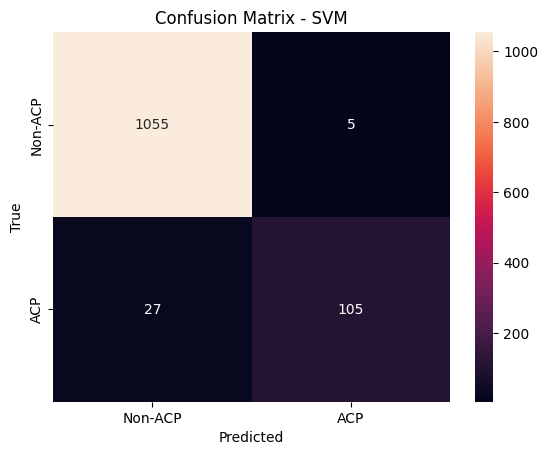

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Non-ACP', 'ACP'],
            yticklabels=['Non-ACP', 'ACP'])
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
cross_val_score(svm, X, y, cv=kfold, scoring='accuracy').mean()

np.float64(0.9694487056567593)

## Decision Tree

In [ ]:
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
#accuracy of test set
dt.score(X_test,y_test)*100

92.36577181208054

In [ ]:
y_test_pred=dt.predict(X_test)

In [ ]:
#accuracy of train set
y_train_pred = dt.predict(X_train)
accuracy_score(y_train, y_train_pred)*100

100.0

In [ ]:
# classification report
classification_report(y_test,y_test_pred,target_names=['ACP','non-ACP'])

'              precision    recall  f1-score   support\n\n         ACP       0.96      0.96      0.96      1060\n     non-ACP       0.65      0.66      0.66       132\n\n    accuracy                           0.92      1192\n   macro avg       0.81      0.81      0.81      1192\nweighted avg       0.92      0.92      0.92      1192\n'

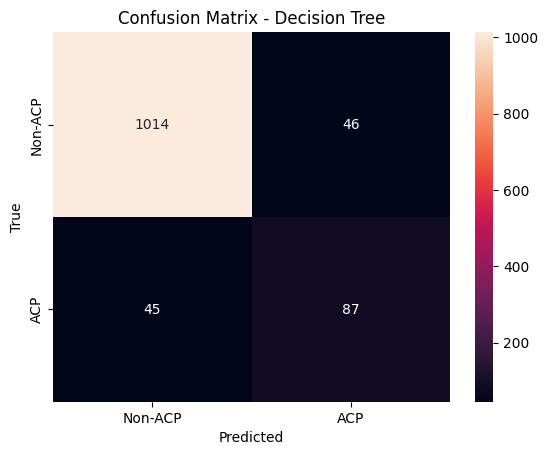

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Non-ACP', 'ACP'],
            yticklabels=['Non-ACP', 'ACP'])
plt.title("Confusion Matrix - Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
cross_val_score(dt, X, y, cv=kfold, scoring='accuracy').mean()

np.float64(0.9296638655462186)

## Random Forest

In [ ]:
rf=RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [ ]:
#accuracy of test set
rf.score(X_test,y_test)*100

95.38590604026845

In [ ]:
y_test_pred=rf.predict(X_test)

In [ ]:
#accuracy of train set
y_train_pred = dt.predict(X_train)
accuracy_score(y_train, y_train_pred)*100

100.0

In [ ]:
# classification report
classification_report(y_test,y_test_pred,target_names=['ACP','non-ACP'])

'              precision    recall  f1-score   support\n\n         ACP       0.95      1.00      0.97      1060\n     non-ACP       1.00      0.58      0.74       132\n\n    accuracy                           0.95      1192\n   macro avg       0.98      0.79      0.86      1192\nweighted avg       0.96      0.95      0.95      1192\n'

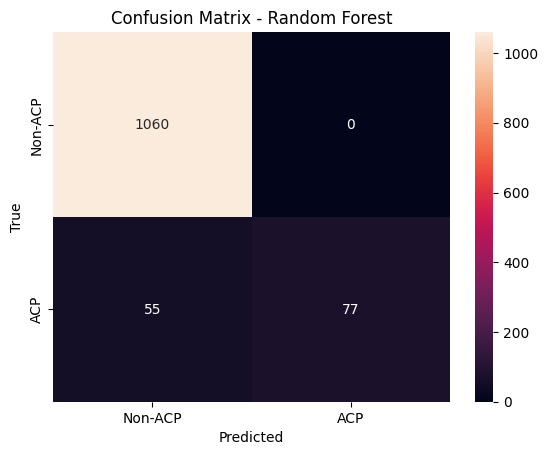

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Non-ACP', 'ACP'],
            yticklabels=['Non-ACP', 'ACP'])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
cross_val_score(rf, X, y, cv=kfold, scoring='accuracy').mean()

np.float64(0.9571947436692797)

## LGBM

In [ ]:
lgbm=LGBMClassifier(class_weight='balanced')
lgbm.fit(X_train,y_train)

LGBMClassifier(class_weight='balanced')

In [ ]:
#accuracy of test set
lgbm.score(X_test,y_test)*100

97.23154362416108

In [ ]:
y_test_pred=lgbm.predict(X_test)

In [ ]:
#accuracy of train set
y_train_pred = dt.predict(X_train)
accuracy_score(y_train, y_train_pred)*100

100.0

In [ ]:
# classification report
classification_report(y_test,y_test_pred,target_names=['ACP','non-ACP'])

'              precision    recall  f1-score   support\n\n         ACP       0.98      0.99      0.98      1060\n     non-ACP       0.88      0.86      0.87       132\n\n    accuracy                           0.97      1192\n   macro avg       0.93      0.92      0.93      1192\nweighted avg       0.97      0.97      0.97      1192\n'

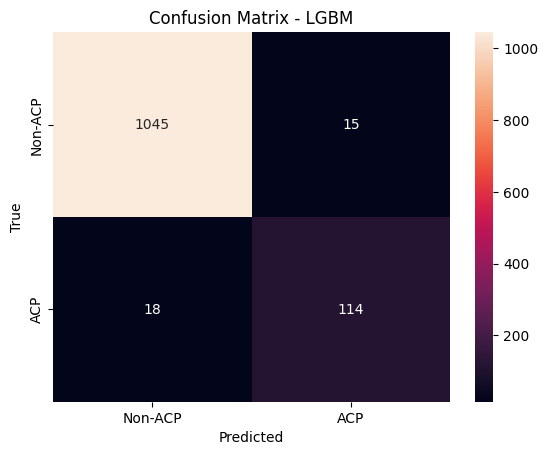

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Non-ACP', 'ACP'],
            yticklabels=['Non-ACP', 'ACP'])
plt.title("Confusion Matrix - LGBM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
cross_val_score(lgbm, X, y, cv=kfold, scoring='accuracy').mean()

np.float64(0.9667632959223958)

## XGBoost

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
#accuracy of test set
xgb.score(X_test,y_test)*100

97.23154362416108

In [ ]:
y_test_pred=xgb.predict(X_test)

In [ ]:
#accuracy of train set
y_train_pred = dt.predict(X_train)
accuracy_score(y_train, y_train_pred)*100

100.0

In [ ]:
# classification report
classification_report(y_test,y_test_pred,target_names=['ACP','non-ACP'])

'              precision    recall  f1-score   support\n\n         ACP       0.98      0.99      0.98      1060\n     non-ACP       0.92      0.82      0.87       132\n\n    accuracy                           0.97      1192\n   macro avg       0.95      0.90      0.93      1192\nweighted avg       0.97      0.97      0.97      1192\n'

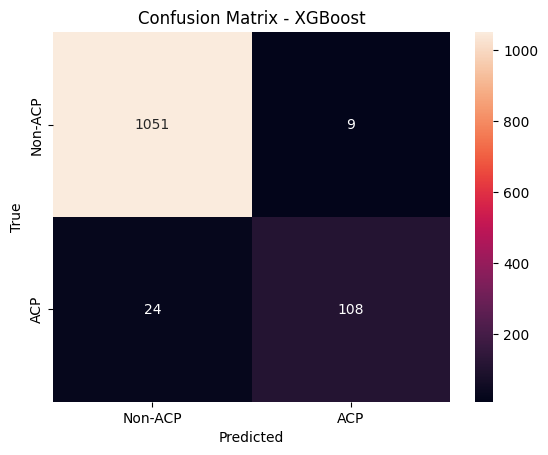

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Non-ACP', 'ACP'],
            yticklabels=['Non-ACP', 'ACP'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
cross_val_score(xgb, X, y, cv=kfold, scoring='accuracy').mean()

np.float64(0.9699529073374317)

## Bagging Classifier

In [ ]:
bg=BaggingClassifier(estimator=SVC(probability=True,kernel='rbf',class_weight='balanced'))
bg.fit(X_train,y_train)

BaggingClassifier(estimator=SVC(class_weight='balanced', probability=True))

In [ ]:
bg.score(X_test,y_test)*100

97.3993288590604

In [ ]:
y_test_pred=bg.predict(X_test)

In [ ]:
#accuracy of train set
y_train_pred = bg.predict(X_train)
accuracy_score(y_train, y_train_pred)*100

99.72717733473242

In [ ]:
# classification report
classification_report(y_test,y_test_pred,target_names=['ACP','non-ACP'])

'              precision    recall  f1-score   support\n\n         ACP       0.98      0.99      0.99      1060\n     non-ACP       0.95      0.81      0.87       132\n\n    accuracy                           0.97      1192\n   macro avg       0.96      0.90      0.93      1192\nweighted avg       0.97      0.97      0.97      1192\n'

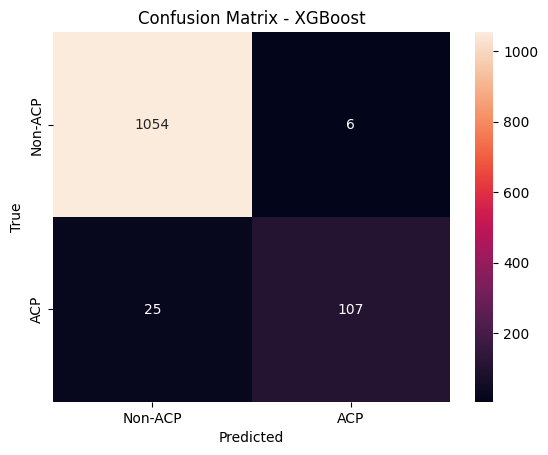

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Non-ACP', 'ACP'],
            yticklabels=['Non-ACP', 'ACP'])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Model Evaluation
Evaluate models using Accuracy, Precision, Recall, F1-score, ROC-AUC and MCC. Plot ROC curves.


In [ ]:
models = {
    "SVM": svm,
    "Decision Tree": dt,
    "Random Forest": rf,
    "LightGBM": lgbm,
    "XGBoost": xgb,
    "Bagging Classifier": bg
}

### Scores

In [ ]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred

    # Confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    scores = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred) * 100,
        "Precision": precision_score(y_test, y_pred) * 100,
        "Recall(Sensitivity)": recall_score(y_test, y_pred,  pos_label=1) * 100, #Sensitivity (ACP recall)
        "Specificity": (tn / (tn + fp)) * 100, # Specificity (non-ACP recall)
        "F1 Score": f1_score(y_test, y_pred) * 100,
        "ROC AUC": roc_auc_score(y_test, y_proba) * 100,
        "MCC": matthews_corrcoef(y_test, y_pred),
        "ACP": tp,       # correctly predicted positives
        "non-ACP": tn    # correctly predicted negatives
    }

    return scores

In [ ]:
model_scores=[]
for name, model in models.items():
    score = evaluate_model(name, model, X_test, y_test)
    model_scores.append(score)

In [ ]:
model_scores = pd.DataFrame(model_scores).set_index("Model").round(4)
model_scores= model_scores.sort_values(by='Accuracy', ascending=False)
model_scores

,Accuracy,Precision,Recall(Sensitivity),Specificity,F1 Score,ROC AUC,MCC,ACP,non-ACP
Model,,,,,,,,,
SVM,97.32,95.45,79.55,99.53,86.78,97.49,0.86,105,1055
LightGBM,97.23,88.37,86.36,98.58,87.36,97.81,0.86,114,1045
XGBoost,97.23,92.31,81.82,99.15,86.75,97.70,0.85,108,1051
Bagging Classifier,97.06,93.69,78.79,99.34,85.60,97.46,0.84,104,1053
Random Forest,95.39,100.00,58.33,100.00,73.68,97.29,0.74,77,1060
Decision Tree,92.37,65.41,65.91,95.66,65.66,80.78,0.61,87,1014


**Top 4 Model:**
- **Bagging Classifier:** Highest accuracy, but recall & F1 are lower.
-  **SVM:** 2nd Highest accuracy
- **LightGBM:** Best recall & F1, most balanced overall.
- **XGBoost:** Balanced, slightly behind LightGBM.

### ROC Curve

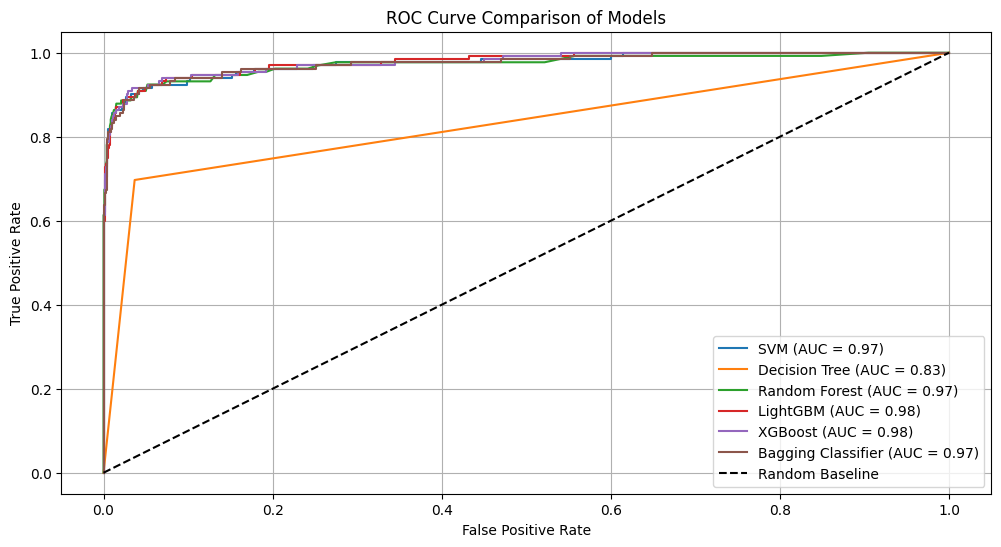

In [ ]:
plt.figure(figsize=(12, 6))


for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # For models like SVM without predict_proba by default
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # normalize to 0–1

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")


plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')

plt.title("ROC Curve Comparison of Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc="lower right")
plt.grid(True)

plt.show()

# Base-Models Comparison

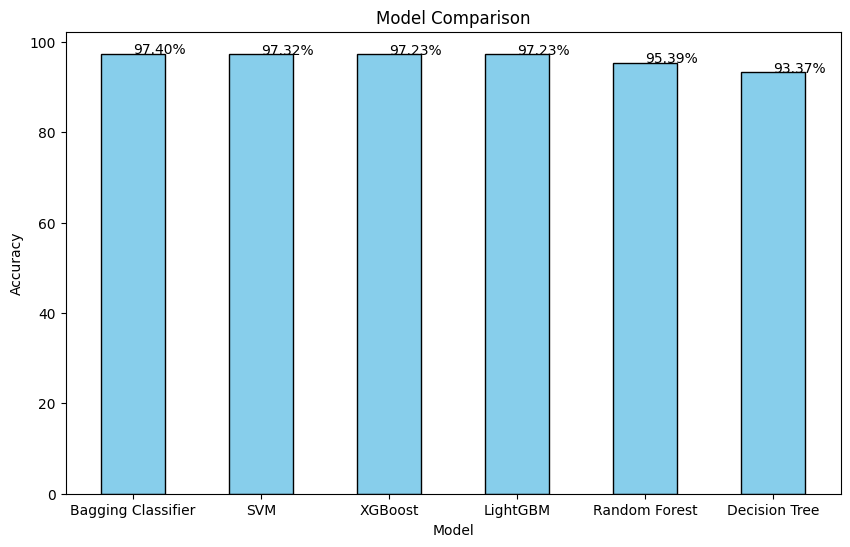

In [ ]:
plt.figure(figsize=(10, 6))

plt.bar(model_scores.index,model_scores['Accuracy'],color='skyblue',edgecolor='black',width=0.5)

# Adding accuracy labels on top of each bar
for i, value in enumerate(model_scores['Accuracy']):
    plt.text(i, value + 0.002, f"{value:.2f}%")

plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Models Comparison using Lazypredict
Compare algorithms using LazyPredict to quickly benchmark multiple models.

In [ ]:
clf=LazyClassifier(verbose=0, ignore_warnings=True)
models,predictions=clf.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
models.head(10)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.97,0.90,0.90,0.97,2.53
LGBMClassifier,0.97,0.90,0.90,0.97,2.60
NearestCentroid,0.91,0.86,0.86,0.91,0.72
GaussianNB,0.86,0.85,0.85,0.88,0.33
KNeighborsClassifier,0.92,0.85,0.85,0.92,0.63
LinearDiscriminantAnalysis,0.95,0.85,0.85,0.95,2.21
SVC,0.96,0.84,0.84,0.96,7.82
BernoulliNB,0.90,0.84,0.84,0.90,0.63
BaggingClassifier,0.96,0.84,0.84,0.95,8.06


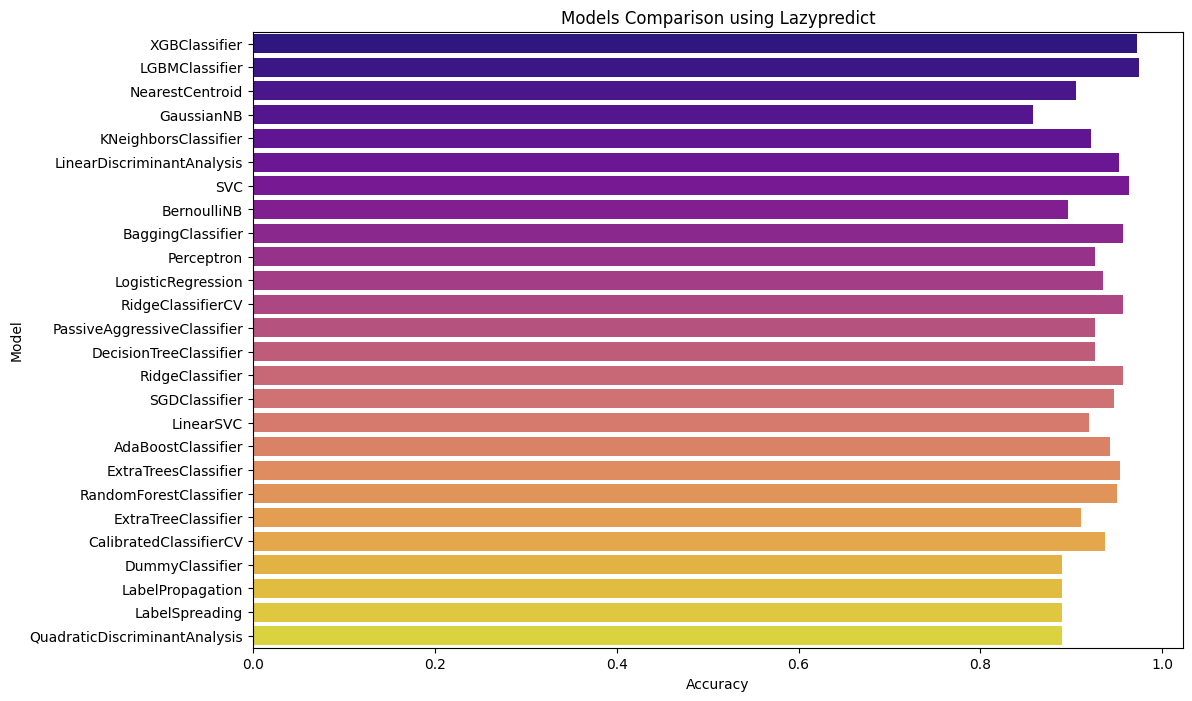

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x="Accuracy", y="Model", data=models, palette="plasma")
plt.title("Models Comparison using Lazypredict")
plt.show()

# Best Model
Identify and save the best-performing single model with its evaluation metrics.


In [ ]:
best_model_name = models['Accuracy'].idxmax()
best_model_name

'LGBMClassifier'

In [ ]:
best_model=lgbm

joblib.dump(best_model, "/content/drive/My Drive/Drug Prediction from ACPs/Best_ACP_Model_LGBM.joblib")

['/content/drive/My Drive/Drug Prediction from ACPs/Best_ACP_Model_LGBM.joblib']

# Ensemble Model
Build an ensemble (e.g., soft voting) of top models (SVM,LightGBM,XGBoost,Bagging Classifier) for improved prediction performance.

In [ ]:
ensemble_model = VotingClassifier(
    estimators=[
        ('SVM', svm),
        ('LightBGM', lgbm),
        ('XGBoost', xgb),
        ('Bagging Classifier',bg)
    ],

    voting='soft'
)

In [ ]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('SVM',
                              SVC(class_weight='balanced', probability=True)),
                             ('LightBGM',
                              LGBMClassifier(class_weight='balanced')),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='l...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('Bagging Classifier',
                              BaggingClassifier(estimator=SVC(class_weight='balanced',
                                                              probability=True)))],
                 voting='soft')

In [ ]:
#accuracy of test case
ensemble_model.score(X_test,y_test)*100  #97.48322147651007

97.48322147651007

In [ ]:
#accuracy of train data
y_train_pred = ensemble_model.predict(X_train)
accuracy_score(y_train, y_train_pred)*100

100.0

In [ ]:
# CV score
kfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=42)
cv_score = cross_val_score(ensemble_model, X, y, cv=kfold, scoring='accuracy').mean()
cv_score*100

In [ ]:
y_pred= ensemble_model.predict(X_test)
y_proba = ensemble_model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred

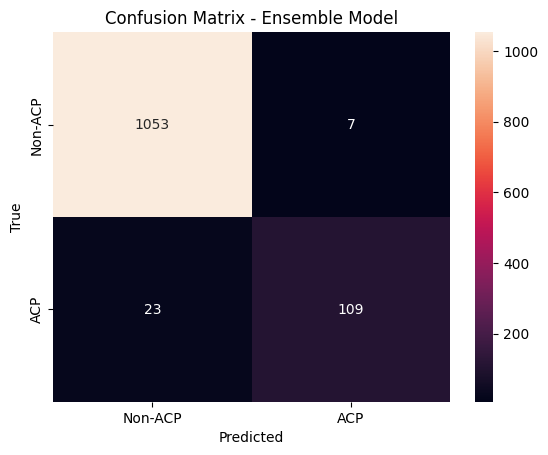

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Non-ACP', 'ACP'],
            yticklabels=['Non-ACP', 'ACP'])
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Evaluate Scores

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

ensemble_model_scores = {
    "Model": ["Ensemble Model"],
    "Accuracy": [accuracy_score(y_test, y_pred) * 100],
    "Precision": [precision_score(y_test, y_pred) * 100],
    "Recall(Sensitivity)": [recall_score(y_test, y_pred) * 100],  # Sensitivity
    "Specificity": [(tn / (tn + fp)) * 100],
    "F1 Score": [f1_score(y_test, y_pred) * 100],
    "ROC AUC": [roc_auc_score(y_test, y_proba) * 100],
    "MCC": [matthews_corrcoef(y_test, y_pred)],
    "ACP": tp,       # correctly predicted positives
    "non-ACP": tn    # correctly predicted negatives
}

ensemble_model_scores = pd.DataFrame(ensemble_model_scores).set_index("Model").round(4)
ensemble_model_scores

,Accuracy,Precision,Recall(Sensitivity),Specificity,F1 Score,ROC AUC,MCC,ACP,non-ACP
Model,,,,,,,,,
Ensemble Model,97.48,93.97,82.58,99.34,87.90,97.87,0.87,109,1053


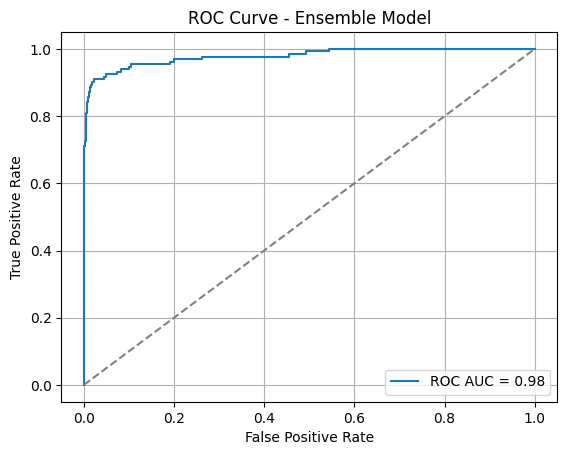

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Ensemble Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

## Save the Ensemble Model
Save the trained ensemble model for future use and reproducibility.

In [ ]:
joblib.dump(ensemble_model, "/content/drive/My Drive/Drug Prediction from ACPs/Ensemble_ACP_Model.joblib")

['/content/drive/My Drive/Drug Prediction from ACPs/Ensemble_ACP_Model.joblib']

# Models Report
Create DataFrame to store all models report and plot a graph for analysis.

In [ ]:
models_report=pd.concat([ensemble_model_scores,model_scores])
models_report

,Accuracy,Precision,Recall(Sensitivity),Specificity,F1 Score,ROC AUC,MCC,ACP,non-ACP
Model,,,,,,,,,
Ensemble Model,97.48,93.97,82.58,99.34,87.90,97.87,0.87,109,1053
Bagging Classifier,97.40,94.69,81.06,99.43,87.35,97.49,0.86,107,1054
SVM,97.32,95.45,79.55,99.53,86.78,97.50,0.86,105,1055
XGBoost,97.23,92.31,81.82,99.15,86.75,97.70,0.85,108,1051
LightGBM,97.23,88.37,86.36,98.58,87.36,97.81,0.86,114,1045
Random Forest,95.39,100.00,58.33,100.00,73.68,97.29,0.74,77,1060
Decision Tree,93.37,70.23,69.70,96.32,69.96,83.01,0.66,92,1021


The ensemble model achieved strong performance (97.48% accuracy).

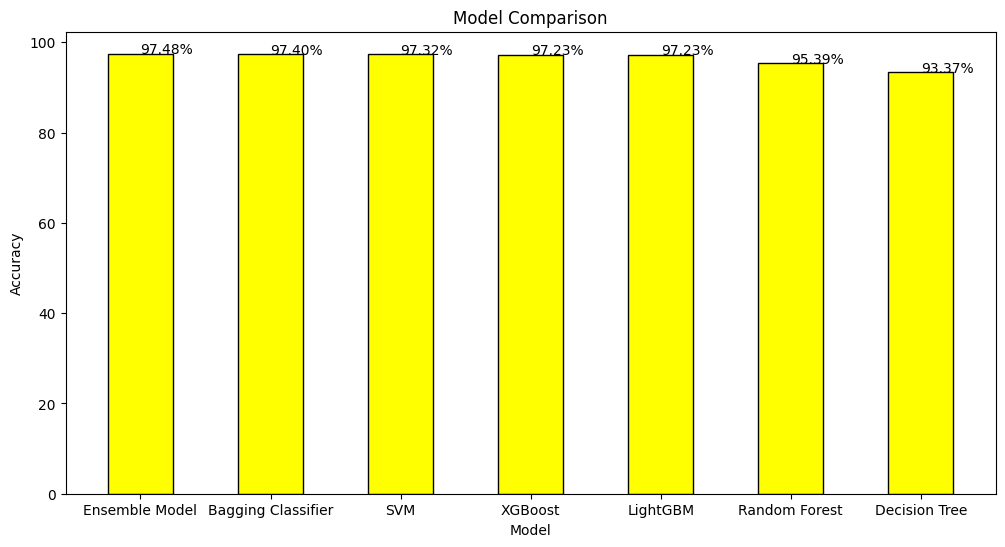

In [ ]:
plt.figure(figsize=(12, 6))

plt.bar(models_report.index, models_report['Accuracy'],color=['yellow'],edgecolor='black',width=0.5)

# Adding accuracy labels on top of each bar
for i, value in enumerate(models_report['Accuracy']):
    plt.text(i, value + 0.002, f"{value:.2f}%")

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')

plt.show()

In [ ]:
# save report as a csv file
models_report.to_csv("/content/drive/My Drive/Drug Prediction from ACPs/Model_Report.csv",index=True)

# Feature Importance- LGBM
Analyze important features with LightGBM and visualize top contributors for interpretability.

In [ ]:
lgbm_importances = lgbm.feature_importances_

In [ ]:
feature_names = X.columns

lgbm_features_df=pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgbm_importances
})
lgbm_features_df=lgbm_features_df.sort_values(by='Importance', ascending=False)

# show top 20 features
top20 = lgbm_features_df.head(20)
display(top20)

,Feature,Importance
512,PCP_Z4,161
8,AAC_K,120
1,AAC_C,114
509,PCP_Z1,84
14,AAC_R,65
511,PCP_Z3,58
3,AAC_E,56
10,AAC_M,51
6,AAC_H,49
9,AAC_L,46


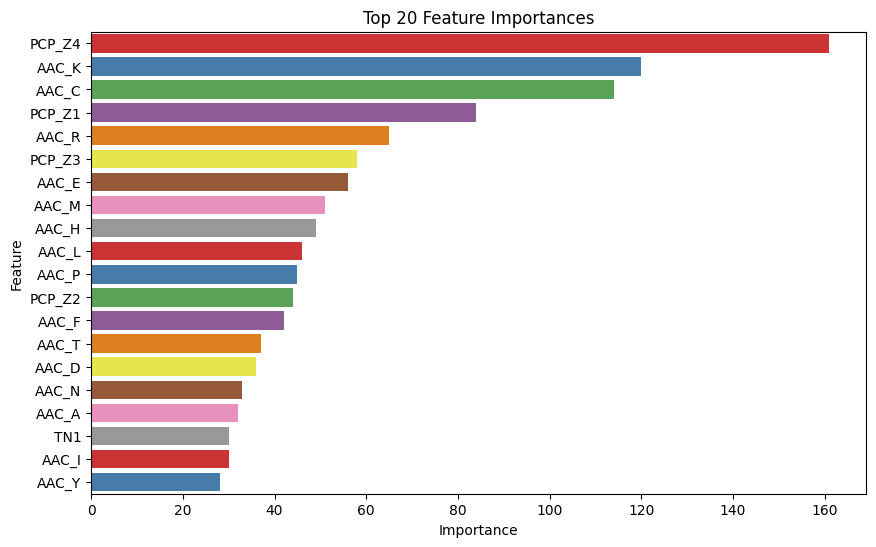

In [ ]:
# Visualize Top 20 Features
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=top20,palette="Set1")
plt.title("Top 20 Feature Importances")
plt.show()

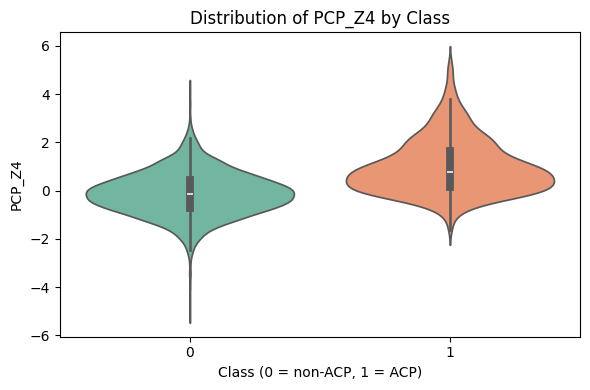

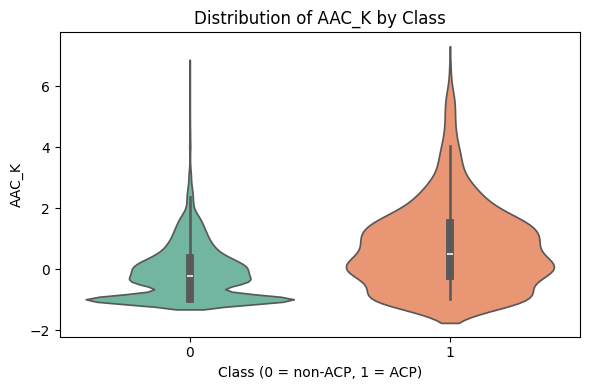

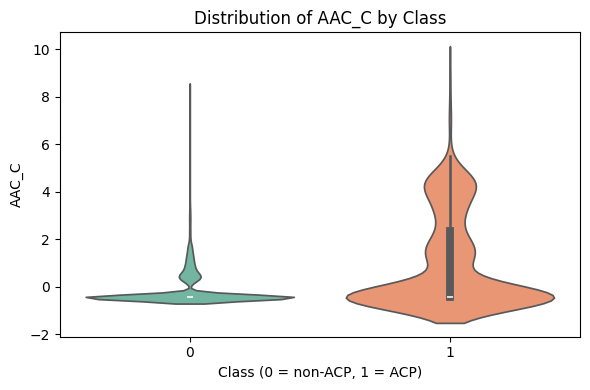

In [ ]:
# Distribution of Top 3 Features (ACP vs non-ACP)

top_feats = top20["Feature"].head(3).tolist()

for feature in top_feats:
    plt.figure(figsize=(6,4))
    sns.violinplot(x=y, y=X[feature], palette="Set2")
    plt.title(f"Distribution of {feature} by Class")
    plt.xlabel("Class (0 = non-ACP, 1 = ACP)")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

<Figure size 2000x2000 with 0 Axes>

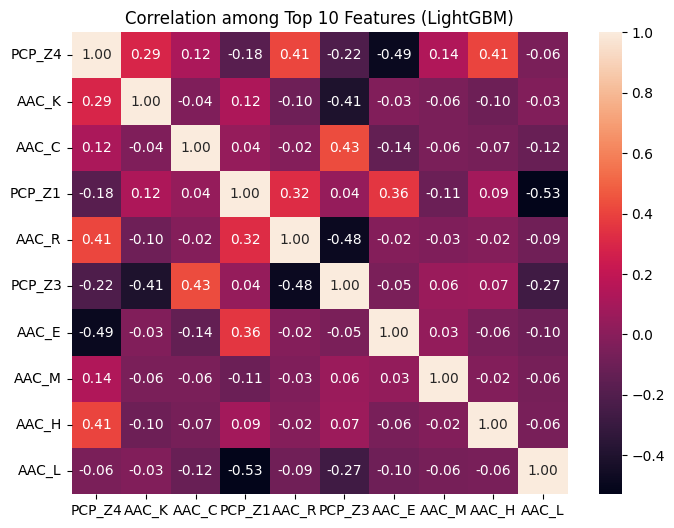

In [ ]:
plt.figure(figsize=(20,20))

selected_feats = top20["Feature"].head(10).tolist()   # top 10 features
corr = X[selected_feats].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation among Top 10 Features (LightGBM)")
plt.show()

In [ ]:
lgbm_features_df.to_csv("/content/drive/My Drive/Drug Prediction from ACPs/LGBM_Features_Importance.csv",index=True)

# Conclusion

We successfully built an **ensemble machine learning framework** for anticancer peptide prediction.
- Achieved high accuracy (≈97.5%) on the test dataset  
- Ensemble improved model stability compared to individual models  
- LightGBM feature importance and SHAP analysis provided insights into key biological descriptors  

This framework can help in **prioritizing peptide drug candidates** and can be extended to other peptide-based prediction tasks.

# Future Scope  
- Expand dataset for better generalization.  
- Explore deep learning (CNN, RNN, Transformers).  
- Extend prediction to toxicity/solubility.  
- Integrate **molecular docking** for peptide–protein interaction validation.  
- Perform **PCA analysis** for dimensionality reduction & visualization.
- Deploy as a **web app/API** for researchers to input sequences and get predictions.  
